In [1]:
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [2]:
# Compute inertia and assign labels to closest centroid
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

def compute_inertia(centroids, data, threshold=100000, distance_metric='euclidean'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia

In [3]:
class Firefly:
    def __init__(self, data, n_clusters):
        self.position = data[np.random.choice(data.shape[0], n_clusters, replace=False), :]
        self.fitness = compute_inertia(self.position, data)


In [4]:
def firefly_kmeans(data, n_clusters, n_fireflies=10, max_iter=100, alpha=0.5, gamma=1.0):
    fireflies = [Firefly(data, n_clusters) for _ in range(n_fireflies)]

    for _ in range(max_iter):
        fireflies.sort(key=lambda x: x.fitness)
        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if fireflies[j].fitness < fireflies[i].fitness:  # Move i towards j
                    r = np.linalg.norm(fireflies[i].position - fireflies[j].position)
                    beta0 = 1
                    beta = beta0 * np.exp(-gamma * r**2)
                    fireflies[i].position += beta * (fireflies[j].position - fireflies[i].position) + alpha * (np.random.rand(*fireflies[i].position.shape) - 0.5)
                    fireflies[i].fitness = compute_inertia(fireflies[i].position, data)

    best_firefly = fireflies[0]
    final_kmeans = KMeans(n_clusters=n_clusters, init=np.array(best_firefly.position), n_init=1, max_iter=300)
    final_kmeans.fit(data)
    return final_kmeans

In [5]:
newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)

In [6]:
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)

In [8]:
processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]
# Use TfidfVectorizer to convert the raw text into TF-IDF features
print("Vectorizing the text data...")
tfidf_vectorizer = CountVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_data)
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)


Vectorizing the text data...


In [9]:
if tfidf_matrix_reduced.dtype == 'float64':
    tfidf_matrix_reduced = tfidf_matrix_reduced.astype('float32')

In [10]:
n_clusters = 20
kmeans = firefly_kmeans(tfidf_matrix_reduced, n_clusters)
print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)
#Firefly-Kmeans on 20newsgroups


Cluster centers: [[ 3.1455040e-02  1.9598429e+01  1.7179318e-02 ... -1.4953191e+00
   7.7392226e-01  1.6810876e+00]
 [ 7.4753761e-03  1.8723436e+01 -1.5537143e-01 ...  6.0645634e-01
   2.4249852e-01 -3.2502455e-01]
 [ 5.1758051e-02  4.8454414e+01  1.1990869e+00 ... -3.0532399e-01
  -1.8798107e-01 -1.3856543e-02]
 ...
 [ 1.7081189e-01  3.1408291e+01  9.7976303e+00 ... -8.2656127e-01
  -4.3289590e-01 -3.7248239e-01]
 [ 6.1805248e-03  9.5795155e+00  1.1733319e-01 ...  6.2279236e-01
   3.0755270e-02 -2.3117356e-01]
 [ 2.7606916e-01  6.2049031e+00  3.3760271e+00 ... -3.0970180e-01
  -2.7859988e+00 -6.9214541e-01]]
Labels: [4 4 4 ... 4 4 4]


In [11]:
silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Silhouette Score: 0.6669077277183533
Davies-Bouldin Index: 1.8149073041241923
Calinski-Harabasz Index: 47745.25988670855


In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
Labels_save=[];
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    kmeans =  firefly_kmeans(tfidf_matrix_reduced, n_clusters)
    
    # Calculate metrics
    silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
    print(silhouette)
    davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)
    
    # Store metrics
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)
#     pca = PCA(n_components=2)
#     pca_data = pca.fit_transform(tfidf_matrix_reduced)

# # Visualizing the clusters
#     plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_)
#     plt.title(f'PCA of KMeans Clusters ({n_clusters} Clusters)')
#     plt.show()

0.99854606
0.96139103
0.95376194
0.9585693
0.9028944
0.89169836
0.77248585
0.8918965
0.7740748
0.7707262
0.6893455
0.5333342
0.58051616
0.67041355
0.6783303
0.72227776
0.49552605
0.6176105
0.49542385


C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_24820\1463608575.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_24820\1463608575.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


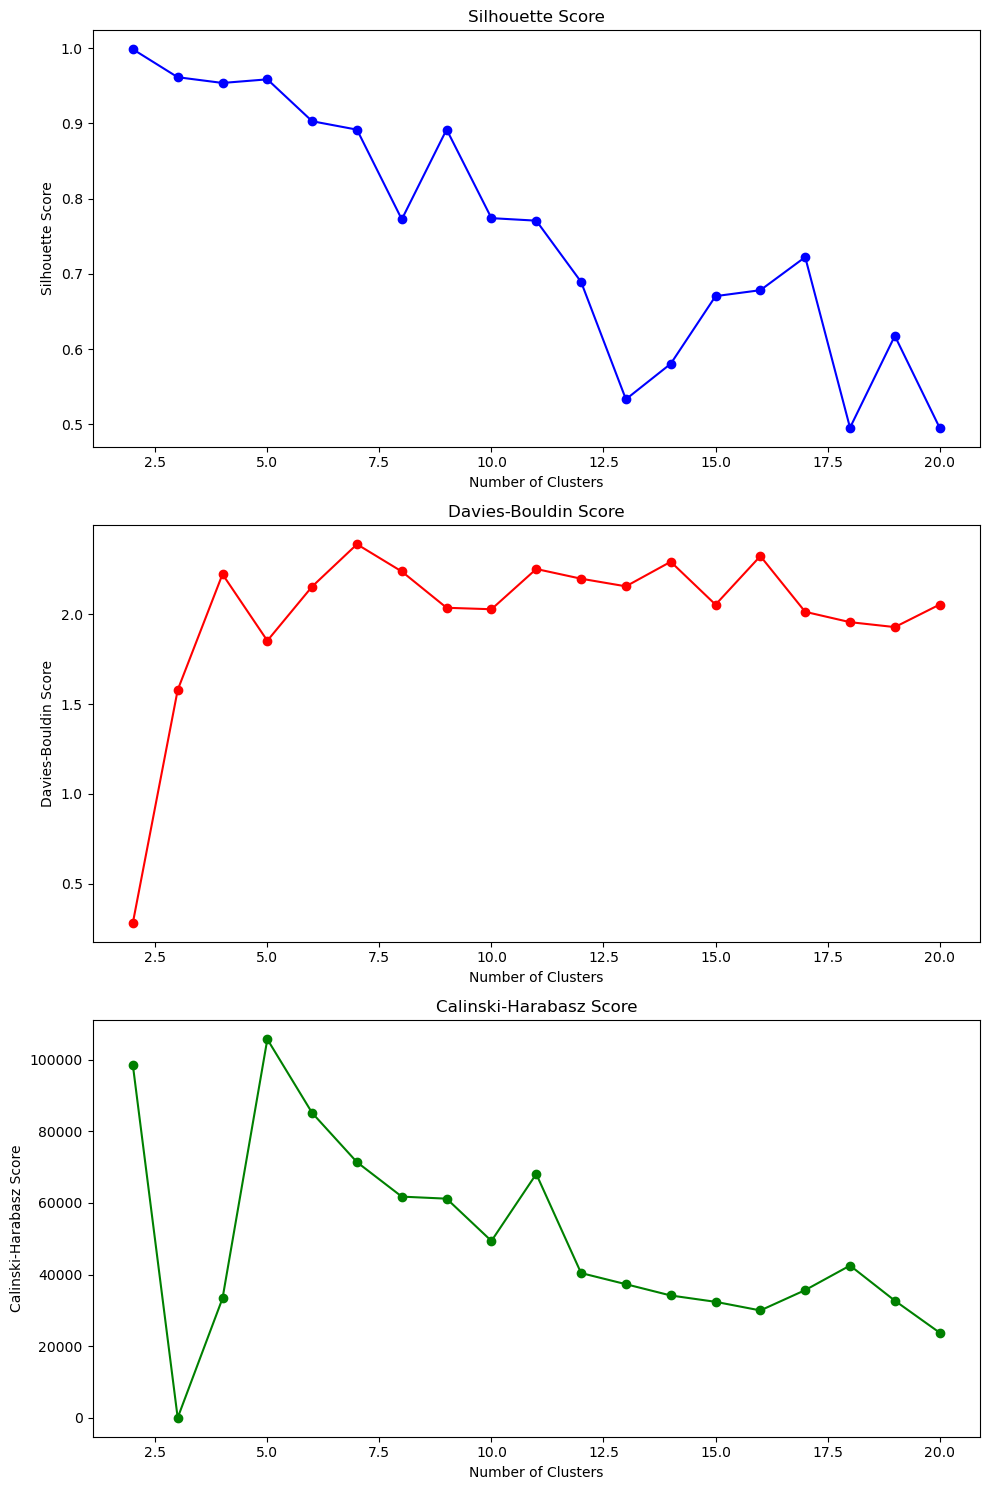

In [14]:
import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_count_firefly-Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_count_firefly-Kmeans.png")
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
data = {'Silhouette Score':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))
df

,Silhouette Score,davies_bouldin_scores,calinski_harabasz_scores
2,0.998546,0.282495,98424.378550
3,0.961391,1.578931,18.843372
4,0.953762,2.223606,33342.084977
5,0.958569,1.853318,105676.152372
6,0.902894,2.155072,85112.853267
7,0.891698,2.390380,71366.128951
8,0.772486,2.238704,61751.675714
9,0.891896,2.036701,61182.048430
10,0.774075,2.028535,49380.905410
11,0.770726,2.252659,68078.523113


In [16]:
df.to_csv('News_count_FIREFLY-Kmeans.csv')